En nuestra parada n1, hemos realizado la transformación logarítmica del gráfico de Bitcoin, asumiendo el carácter no estacionario de la serie. Pero en esta oportunidad, haremos uso de algunos tests que nos brindan información más precisa sobre la variabilidad de nuestros datos.

*At our stop number 1, we performed the logarithmic transformation of the Bitcoin graph, assuming the non-stationary nature of the series. But this time, we will use some tests that provide us with more precise information about the variability of our data.*

In [ ]:
# Import libraries
import random
import numpy as np
import pandas as pd
import requests

# Date
import datetime as dt
from datetime import date, timedelta, datetime
import time

# EDA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import math


# Time Series - EDA and Modelling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import scipy.stats as stats
from itertools import product

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('BTC.csv',
            index_col = "date",
            parse_dates = True).asfreq("D")

In [ ]:
df.head(3)

,ticker,open,high,low,close
date,,,,,
2010-07-17,BTC,0.04951,0.04951,0.04951,0.04951
2010-07-18,BTC,0.04951,0.08585,0.04951,0.08584
2010-07-19,BTC,0.08584,0.09307,0.07723,0.08080


In [ ]:
df = df.drop(['ticker','open','high', 'low'], axis=1)

In [ ]:
df.rename(columns={'close': 'original_series'}, inplace=True)


Es importante no confundir estacionariedad con estacionalidad (en español los términos son muy parecidos):
"Estacionariedad" se refiere a una propiedad fundamental de una serie de tiempo en la que las características estadísticas, como la media, la varianza y la autocorrelación, se mantienen constantes a lo largo del tiempo.
Por otro lado, la estacionalidad, se refiere a la presencia de patrones o ciclos recurrentes en una serie de tiempo a lo largo del tiempo.
Una serie de tiempo puede ser estacionaria pero no necesariamente tener componentes estacionales, y viceversa.

*It is important not to confuse "stationarity" with "seasonality" (in Spanish, the terms are very similar):*

*"Stationarity" refers to a fundamental property of a time series in which statistical characteristics such as mean, variance, and autocorrelation remain constant over time.*

*On the other hand, "seasonality" refers to the presence of recurring patterns or cycles in a time series over time.*

A time series can be stationary but not necessarily have seasonal components, and vice versa. *texto en cursiva*

### La prueba de Dickey-Fuller aumentada

Una prueba de Dickey-Fuller aumentada (ADF) es un tipo de prueba estadística que determina si una raíz unitaria está presente en los datos de series de tiempo. Las raíces unitarias pueden causar resultados impredecibles en el análisis de series de tiempo. Se forma una hipótesis nula en la prueba de raíz unitaria para determinar qué tan fuertemente los datos de series temporales se ven afectados por una tendencia. Al aceptar la hipótesis nula, aceptamos la evidencia de que los datos de la serie temporal no son estacionarios. Al rechazar la hipótesis nula o aceptar la hipótesis alternativa, aceptamos la evidencia de que los datos de la serie de tiempo son generados por un proceso estacionario. Este proceso también se conoce como tendencia estacionaria. Los valores de la estadística de prueba ADF son negativos. Los valores más bajos de ADF indican un rechazo más fuerte de la hipótesis nula.

*An Augmented Dickey-Fuller test (ADF) is a type of statistical test that determines whether a unit root is present in time series data. Unit roots can lead to unpredictable outcomes in time series analysis. The null hypothesis in the unit root test is formed to gauge how strongly time series data are affected by a trend. By accepting the null hypothesis, we accept the evidence that the time series data is non-stationary. By rejecting the null hypothesis or accepting the alternative hypothesis, we accept the evidence that the time series data is generated by a stationary process. This process is also known as trend-stationary. ADF test statistic values are negative. Lower ADF values indicate a stronger rejection of the null hypothesis.*

In [ ]:
from statsmodels.tsa.stattools import adfuller

def Prueba_Dickey_Fuller(series , column_name):
    print (f'Results of the Dickey-Fuller test for the column: {column_name}')
    print('--------------------------------------------------------')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rejection of the null hypothesis")
        print(f'THE DATA IN THE COLUMN "{column_name}" IS STATIONARY')
        print('--------------------------------------------------------')
    else:
        print("Conclusion:====>")
        print("The null hypothesis cannot be rejected")
        print(f'THE DATA IN THE COLUMN "{column_name}" IS NOT STATIONARY')
        print('--------------------------------------------------------')

In [ ]:
Prueba_Dickey_Fuller(df['original_series'],"original_series")

Results of the Dickey-Fuller test for the column: original_series
--------------------------------------------------------
Test Statistic                   -1.696863
p-value                           0.432729
No Lags Used                     30.000000
Number of observations used    4772.000000
Critical Value (1%)              -3.431721
Critical Value (5%)              -2.862146
Critical Value (10%)             -2.567093
dtype: float64
Conclusion:====>
The null hypothesis cannot be rejected
THE DATA IN THE COLUMN "original_series" IS NOT STATIONARY
--------------------------------------------------------


### Kwiatkowski–Phillips–Schmidt–Shin (KPSS) tests

Es posible que una serie temporal sea no estacionaria, no tenga raíz unitaria y, sin embargo, sea estacionaria de tendencia. A diferencia de la prueba de Dickey Fuller, la presencia de una raíz unitaria no es la hipótesis nula.

La prueba KPSS su utiliza para probar una hipótesis nula que establece que una serie temporal observable es estacionaria alrededor de una tendencia determinista (es decir, estacionaria de tendencia) frente a la alternativa de una raíz unitaria.

*It is possible for a time series to be non-stationary, have no unit root, and yet be trend-stationary. Unlike the Dickey Fuller test, the presence of a unit root is not the null hypothesis.*

*The KPSS test is used to test a null hypothesis that states an observable time series is stationary around a deterministic trend (i.e., trend-stationary) as opposed to the alternative of a unit root.*

In [ ]:
from statsmodels.tsa.stattools import kpss

def Prueba_KPSS(series, column_name):
    stats, p, lags, critical_values = kpss(series, 'ct')
    print('---------------------------------------------------------------')
    print (f'Results of the KPSS test for the column: {column_name}')
    print('---------------------------------------------------------------')
    print(f'Test Statistics: {stats}')
    print(f'p-value: {p}')
    print(f'Critial Values: {critical_values}')
    if p < 0.05 :
      print(f'THE DATA IN THE COLUMN "{column_name}" IS NOT STATIONARY')
      print('---------------------------------------------------------------')
    else:
      print(f'THE DATA IN THE COLUMN "{column_name}" IS STATIONARY')
      print('---------------------------------------------------------------')

In [ ]:
Prueba_KPSS(df['original_series'], 'original_series')

---------------------------------------------------------------
Results of the KPSS test for the column: original_series
---------------------------------------------------------------
Test Statistics: 1.0537830304372156
p-value: 0.01
Critial Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
THE DATA IN THE COLUMN "original_series" IS NOT STATIONARY
---------------------------------------------------------------


### Gráfico Cuantil-Cuantil / *Q-Q plot*

Un gráfico Cuantil-Cuantil permite observar cuan cerca está la
distribución de un conjunto de datos a alguna distribución ideal.

*A Quantile-Quantile plot allows you to observe how close the distribution of a dataset is to an ideal distribution.*

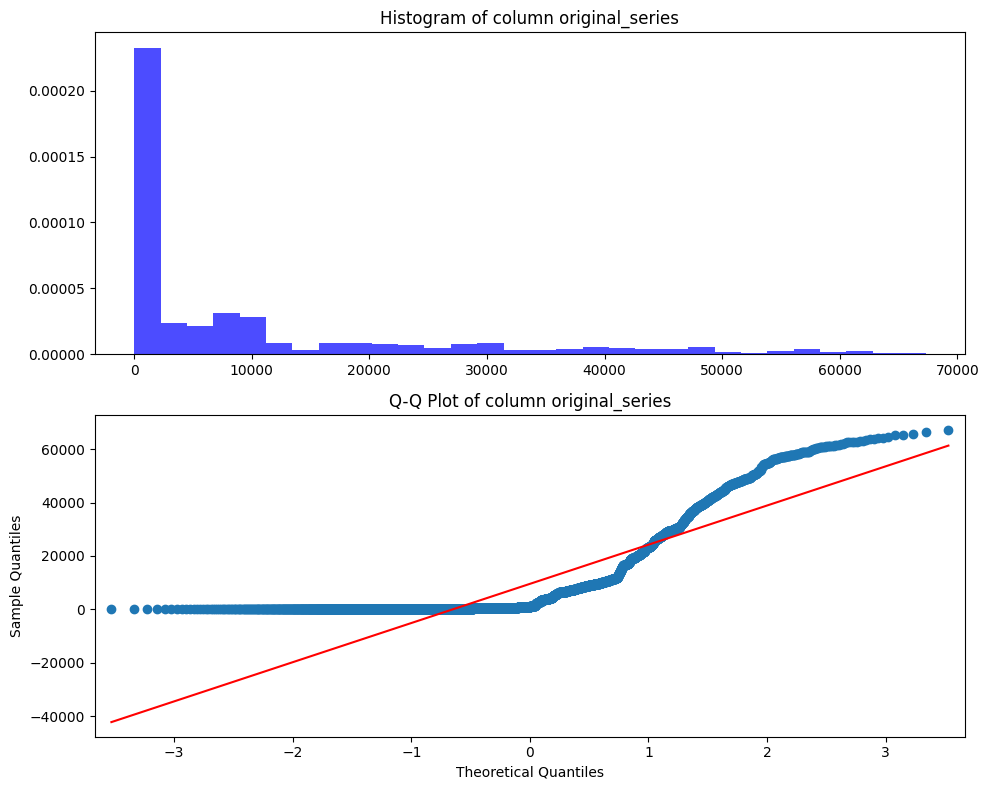

In [ ]:
import statsmodels.api as sm

def plot_normality_test(series, column):
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))

    # Plot the histogram
    ax[0].hist(series, bins=30, density=True, alpha=0.7, color='b')
    ax[0].set_title(f'Histogram of column {column}')

    # Plot the probability plot
    sm.qqplot(series, line='s', ax=ax[1])
    ax[1].set_title(f'Q-Q Plot of column {column}')


    plt.tight_layout()
    plt.show()

plot_normality_test(df['original_series'], 'original_series')

Los test confirmaron aquello que nosotros ya deduciamos tán sólo mirando el gráfico, a saber, que la serie no es estacionaria. Es por esto que realizaremos una serie de pruebas de transformaciones sobre la serie para reducir esta inconsistencia.

*The tests confirmed what we had already inferred just by examining the graph, namely, that the series is not stationary. This is why we will conduct a series of transformation tests on the series to mitigate this inconsistency.*


### Transformación de datos no-normales/ *Non-Normal Data Transformation*

Existen distintas funciones que podemos aplicar a nuestros datos para aproximarlos a una distribución gaussiana.
- Método de diferencia
- Método de raíz cuadrada
- Método Inverso
- Logarítmo Natural
- Método al cuadrádo
- Raiz cúbica


*There are different functions that we can apply to our data to approximate them to a Gaussian distribution.*

*-Difference Method*

*-Square Root Method*

*-Inverse Method*

*-Natural Logarithm*

*-Squaring Method*

*-Cubic Root*



In [ ]:
# Difference Method
df['diff'] = df['original_series'].diff().fillna(method ='bfill')
# Square Root Method
df['sqrt'] = np.sqrt(df['original_series'])
#Inverse Method
df['inverse'] = 1 / df['original_series']
# Natural Logarithm
df['log'] = np.log(df['original_series'])
# Squaring Method
df['squared'] = df['original_series'] ** 2
#Cubic Root Transformation
df["cubic"] = np.cbrt(df['original_series'])


Ya podemos comparar nuestros datos transformados:

*Now we can compare our transformed data:*

In [ ]:
df.head(5)

,original_series,diff,sqrt,inverse,log,squared,cubic
date,,,,,,,
2010-07-17,0.04951,0.03633,0.222508,20.197940,-3.005581,0.002451,0.367196
2010-07-18,0.08584,0.03633,0.292985,11.649581,-2.455270,0.007369,0.441127
2010-07-19,0.08080,-0.00504,0.284253,12.376238,-2.515778,0.006529,0.432318
2010-07-20,0.07474,-0.00606,0.273386,13.379716,-2.593740,0.005586,0.421228
2010-07-21,0.07921,0.00447,0.281443,12.624669,-2.535653,0.006274,0.429464


### Comparación de Gráficos Q-Q / *Q-Q plots comparison*

Observemos los histogramas y los Q-Q plots para cada transformación:

*Let's observe the histograms and the Q-Q plots of each transformation:*

In [ ]:
# We create a function for plotting
def diagnostic_plot(df,column):
    plt.figure(figsize=(7,4))
    plt.subplot(1,2,1)
    plt.title("Histogram")
    df[column].hist(bins=30,edgecolor='black')
    plt.subplot(1,2,2)
    stats.probplot(df[column], dist="norm",plot=plt, rvalue=True)
    plt.title("Q-Q plot")
    plt.suptitle(f'{column} distribution')
    plt.tight_layout()
    plt.show()

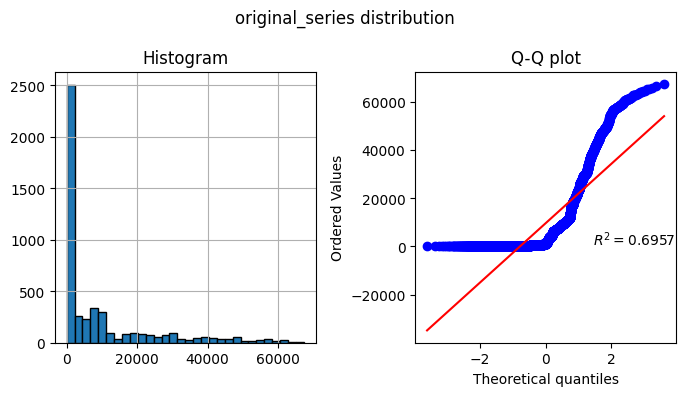

In [ ]:
diagnostic_plot(df,'original_series')

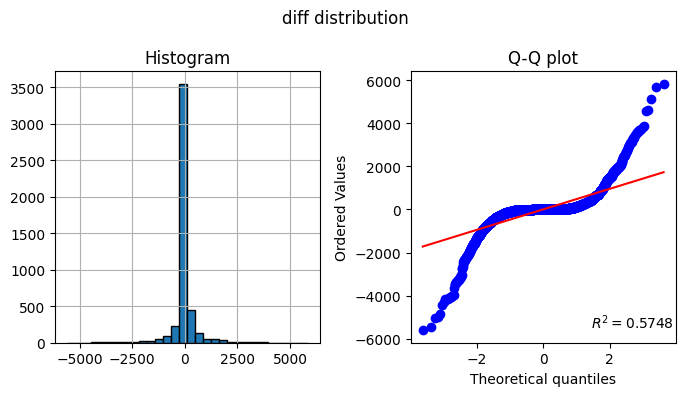

In [ ]:
diagnostic_plot(df,'diff')

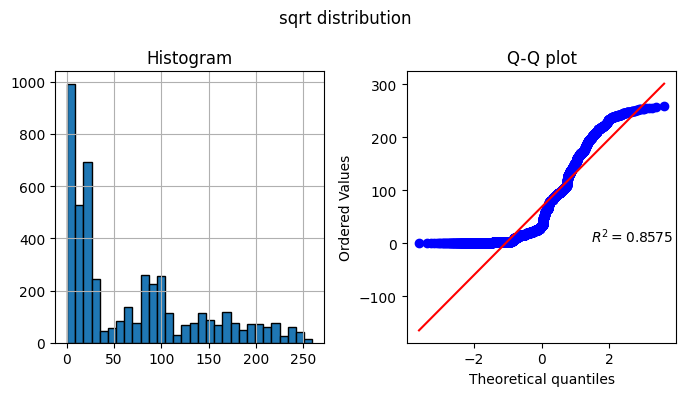

In [ ]:
diagnostic_plot(df,'sqrt')

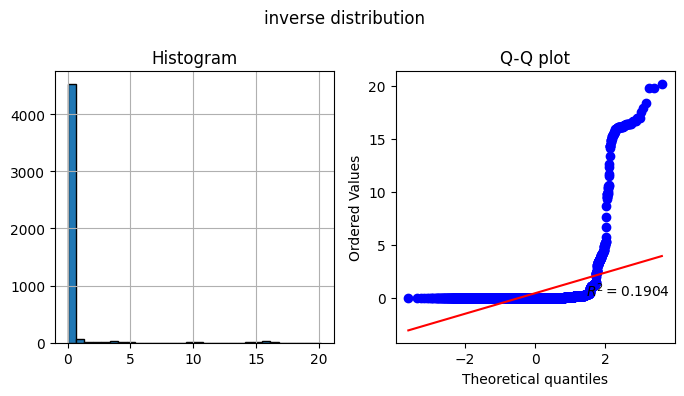

In [ ]:
diagnostic_plot(df,'inverse')

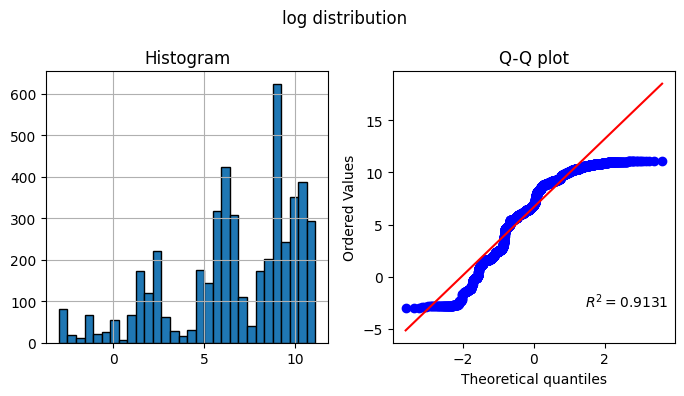

In [ ]:
diagnostic_plot(df,'log')

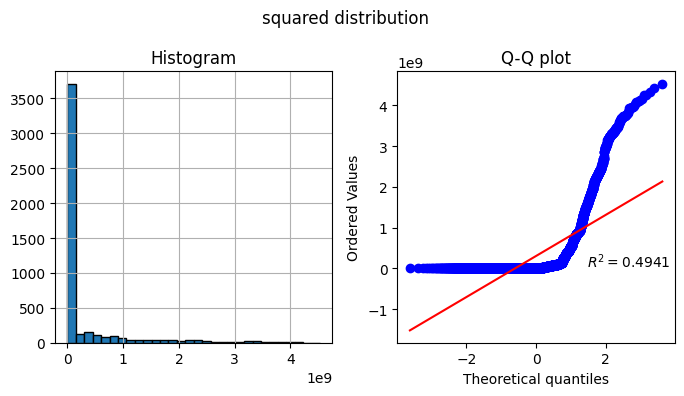

In [ ]:
diagnostic_plot(df,'squared')

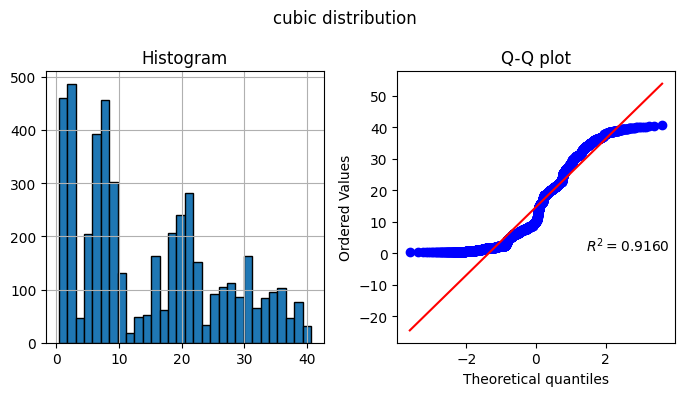

In [ ]:
diagnostic_plot(df,'cubic')

 La interpretación del valor R-squared depende de cuán cerca esté de 1. En general, un valor R-squared cercano a 1 indica un buen ajuste a la distribución normal, mientras que un valor R-squared más bajo indica un ajuste menos preciso. Las transformaciones logarítmicas y de raíz cúbica obtienen valores altos de R-cuadrado, lo que sugiere una mejor aproximación a la distribución normal teórica.

*The interpretation of the R-squared value depends on how close it is to 1. In general, an R-squared value close to 1 indicates a good fit to the normal distribution, while a lower R-squared value indicates a less precise fit. Logarithmic and cubic root transformations achieve high R-squared values, suggesting a better approximation to the theoretical normal distribution.*

### Comparación de p-values/ *P-values comparison*

*Dickey Fuller Test:*

In [ ]:
for column in df.columns:
  Prueba_Dickey_Fuller(df[column],column)

Results of the Dickey-Fuller test for the column: original_series
--------------------------------------------------------
Test Statistic                   -1.696863
p-value                           0.432729
No Lags Used                     30.000000
Number of observations used    4772.000000
Critical Value (1%)              -3.431721
Critical Value (5%)              -2.862146
Critical Value (10%)             -2.567093
dtype: float64
Conclusion:====>
The null hypothesis cannot be rejected
THE DATA IN THE COLUMN "original_series" IS NOT STATIONARY
--------------------------------------------------------
Results of the Dickey-Fuller test for the column: diff
--------------------------------------------------------
Test Statistic                -1.008218e+01
p-value                        1.180646e-17
No Lags Used                   3.200000e+01
Number of observations used    4.770000e+03
Critical Value (1%)           -3.431722e+00
Critical Value (5%)           -2.862146e+00
Critical Valu

*KPSS test:*

In [ ]:
for column in df.columns:
  Prueba_KPSS(df[column],column)

---------------------------------------------------------------
Results of the KPSS test for the column: original_series
---------------------------------------------------------------
Test Statistics: 1.0537830304372156
p-value: 0.01
Critial Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
THE DATA IN THE COLUMN "original_series" IS NOT STATIONARY
---------------------------------------------------------------
---------------------------------------------------------------
Results of the KPSS test for the column: diff
---------------------------------------------------------------
Test Statistics: 0.045677771896933665
p-value: 0.1
Critial Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
THE DATA IN THE COLUMN "diff" IS STATIONARY
---------------------------------------------------------------
---------------------------------------------------------------
Results of the KPSS test for the column: sqrt
-------------------------------------------------------

Los test que hemos realizado sobre estas transformaciones, nos revelaron que, si bien algunas de ellas, podrían llegar a ser útiles para nuestra modelización, ninguna demuestra una performance contundente. Por esta razón, profundizaremos sobre algunas transformaciones un poco más complejas.

*The tests we have conducted on these transformations have revealed that while some of them could potentially be useful for our modeling, none of them show a strong performance. For this reason, we will delve into some more complex transformations.*

### Box-Cox

Es un método de transformación de datos que es capaz de realizar una gama de transformaciones de potencia, incluyendo el logarítmo y la raíz cuadrada. Box-Cox utiliza el valor lambda para encontrar automáticamente la mejor función para ajustar los datos y maximizar la normalidad.

A continuación se presentan algunos valores comunes para lambda:

lambda = -1. es una transformación recíproca.

lambda = -0.5 es una transformada de raíz cuadrada recíproca.

lambda = 0.0 es una transformada de registro.

lambda = 0.5 es una transformada de raíz cuadrada.

lambda = 1.0 no es una transformación.


*It is a data transformation method capable of performing a range of power transformations, including logarithmic and square root transformations. Box-Cox uses the lambda value to automatically find the best function to fit the data and maximize normality.*

*Here are some common values for lambda:*

*- lambda = -1.0 is a reciprocal transformation.*

*- lambda = -0.5 is a reciprocal square root transformation.*

*- lambda = 0.0 is a logarithmic transformation.*

*- lambda = 0.5 is a square root transformation.*

*- lambda = 1.0 is not a transformation. *

In [ ]:
from sklearn.preprocessing import PowerTransformer

# We reshape the input data to a 2D array
original_series_2d = df['original_series'].values.reshape(-1, 1)

# Create a PowerTransformer instance with the 'box-cox' method
boxcoxScaler = PowerTransformer(method='box-cox')

# Fit and transform the data
df['boxcox'] = boxcoxScaler.fit_transform(original_series_2d)

print(f"Lambda Value(s): {boxcoxScaler.lambdas_}")

Lambda Value(s): [0.12997903]


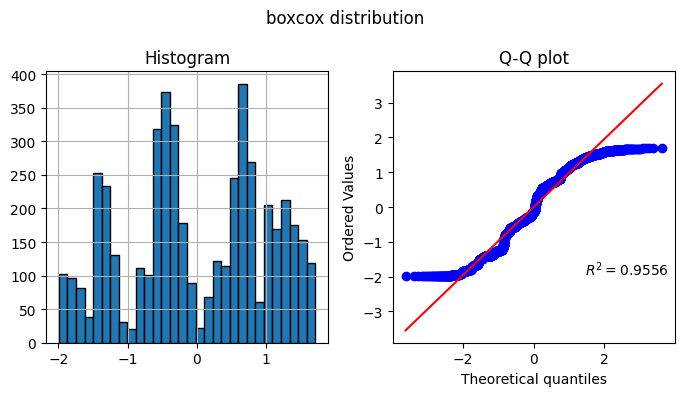

In [ ]:
diagnostic_plot(df,'boxcox')

In [ ]:
Prueba_Dickey_Fuller(df['boxcox'],'boxcox')

Results of the Dickey-Fuller test for the column: boxcox
--------------------------------------------------------
Test Statistic                   -1.657269
p-value                           0.453252
No Lags Used                      8.000000
Number of observations used    4794.000000
Critical Value (1%)              -3.431715
Critical Value (5%)              -2.862143
Critical Value (10%)             -2.567091
dtype: float64
Conclusion:====>
The null hypothesis cannot be rejected
THE DATA IN THE COLUMN "boxcox" IS NOT STATIONARY
--------------------------------------------------------


###  Yeo-Johnson

Es una extensión de la Transformada. La diferencia clave entre la Transformada de Yeo-Johnson y la de Box-Cox radica en cómo manejan los valores negativos y cero.

*It is an extension of the Box-Cox transformation. The key difference between the Yeo-Johnson transformation and the Box-Cox transformation lies in how they handle negative and zero values.*

In [ ]:
# Create a PowerTransformer instance with the 'box-cox' method
YeoScaler = PowerTransformer(method='yeo-johnson')

# Fit and transform the data
df['yeo-johnson'] = YeoScaler.fit_transform(original_series_2d)

print(f"Lambda Value(s): {YeoScaler.lambdas_}")

Lambda Value(s): [0.11422917]


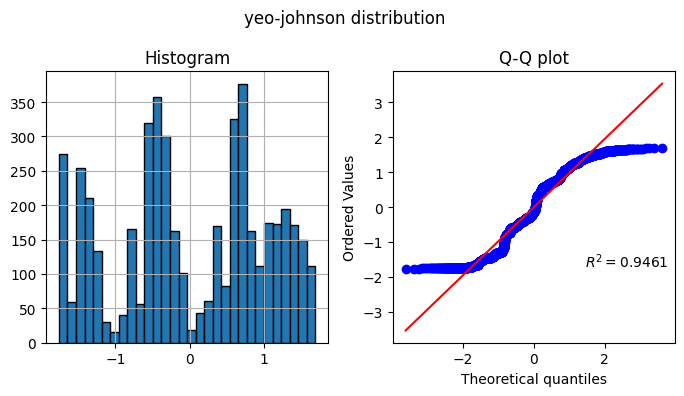

In [ ]:
diagnostic_plot(df,'yeo-johnson')

In [ ]:
Prueba_Dickey_Fuller(df['yeo-johnson'],'yeo-johnson')

Results of the Dickey-Fuller test for the column: yeo-johnson
--------------------------------------------------------
Test Statistic                   -1.300948
p-value                           0.628738
No Lags Used                     11.000000
Number of observations used    4791.000000
Critical Value (1%)              -3.431716
Critical Value (5%)              -2.862143
Critical Value (10%)             -2.567091
dtype: float64
Conclusion:====>
The null hypothesis cannot be rejected
THE DATA IN THE COLUMN "yeo-johnson" IS NOT STATIONARY
--------------------------------------------------------


### Conclusión

En este capitulo hemos aprendido que una serie de tiempo estacionaria no garantiza automáticamente que los datos sigan una distribución normal -pueden seguir otras distribuciones, como la distribución de Poisson, la distribución exponencial, etc-. La estacionariedad se refiere principalmente a la estabilidad de las características estadísticas, no a la forma específica de la distribución de los datos y en nuestros ejemplos pudimos apreciar estas diferencias.
Para nuestros próximos capítulos exploraremos los diversos modelos de predicción para series temporales y observaremos que muchos de ellos realizan las transformaciones de datos por sí mismos, buscando el ajuste óptimo de los mismos.

*In this chapter, we have learned that a stationary time series does not automatically guarantee that the data follows a normal distribution; they can follow other distributions such as the Poisson distribution, the exponential distribution, etc. Stationarity primarily refers to the stability of statistical characteristics, not the specific shape of the data distribution, and in our examples, we could observe these differences.*

*For our upcoming chapters, we will explore various time series prediction models and see that many of them perform data transformations themselves, seeking the optimal fit for the data.*

In [ ]:
#We export the df with all the transformations
df_BTC_withTransformations = "df_BTC_withTransformations.csv"

df.to_csv(df_BTC_withTransformations, index=True)